## Breast Cancel Detection

**Ming He**
**(02-17-2018)**

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

**Variables Information**

1. Sample code number: id number
2. Clump Thickness: 1-10
3. Uniformity of Cell Size: 1-10
4. Uniformity of Cell Shape: 1-10
5. Marginal Adhesion: 1-10
6. Single Epithelial Cell Size: 1-10
7. Bare Nuclei: 1-10
8. Bland Chromatin: 1-10
9. Normal Nucleoli: 1-10
10. Mitoses: 1-10
11. Class: (2 for benign, 4 for malignant)

In [59]:
#Number of Attributes: 10, label: 1
data = pd.read_csv('breast-cancer-data.csv', header = -1)
data.shape

data.columns = ['id','clump_thickness','cell_size_uniformity','cell_shape_uniformity',
                'marginal_adhesion','epithelial_cell_size', 'bare_nuclei','bland_chromatin',
                'normal_nucleoli','mitoses','label']

#Refine the class labels
data['label'] = data['label'].map({2:0,4:1})

#### Is there any missing data?
Yes, Drop data with ?

In [60]:
data = data.replace('?', value = np.nan)

In [61]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
id                       699 non-null int64
clump_thickness          699 non-null int64
cell_size_uniformity     699 non-null int64
cell_shape_uniformity    699 non-null int64
marginal_adhesion        699 non-null int64
epithelial_cell_size     699 non-null int64
bare_nuclei              683 non-null object
bland_chromatin          699 non-null int64
normal_nucleoli          699 non-null int64
mitoses                  699 non-null int64
label                    699 non-null int64
dtypes: int64(10), object(1)
memory usage: 60.1+ KB


In [62]:
data['bare_nuclei'] = list(map(float,data['bare_nuclei']))

In [64]:
data = data.fillna(data.mean())

In [65]:
all_features = ['clump_thickness','cell_size_uniformity','cell_shape_uniformity',
                'marginal_adhesion','epithelial_cell_size', 'bare_nuclei','bland_chromatin',
                'normal_nucleoli','mitoses']
X = data[all_features]
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25)

### Is this data balanced? No

In [67]:
num_samples = data.shape[0]
print('Percentage of Malignant Cases is: {0:.4f}'.format(sum(data['label'] == 1)/num_samples))
print('Percentage Belign Cases is: {0:.4f}'.format(sum(data['label']==0)/num_samples))

Percentage of Malignant Cases is: 0.3448
Percentage Belign Cases is: 0.6552


### Select Most Important Features for Prediction

Feature ranking:
1. feature 5 (0.214699)
2. feature 1 (0.193081)
3. feature 2 (0.149179)
4. feature 7 (0.117786)
5. feature 6 (0.095922)
6. feature 0 (0.089146)
7. feature 3 (0.065835)
8. feature 4 (0.060780)
9. feature 8 (0.013571)


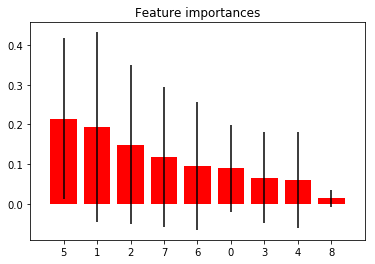

In [70]:
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250, random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

### Get Features Ranked According to Importance

In [71]:
ranked_features = []
for i in range(len(all_features)):
    ranked_features.append(all_features[indices[i]])
ranked_features_df = pd.DataFrame({'Feature': ranked_features,'Rank': list(np.arange(0,9))})
ranked_features_df 

,Feature,Rank
0,bare_nuclei,0
1,cell_size_uniformity,1
2,cell_shape_uniformity,2
3,normal_nucleoli,3
4,bland_chromatin,4
5,clump_thickness,5
6,marginal_adhesion,6
7,epithelial_cell_size,7
8,mitoses,8


### Logistic Classifier

We choose to use Logistic Classifier over SVM for Interpretability. Below we choose number of most important features to include by trying different total numbers and plot ROC curve and AUC.

In [72]:
fpr, tpr, thresholds, auc = [], [], [], []
for i in np.arange(3,10,2):
    features_subset = ranked_features[0:i]
    X_train_subset, X_test_subset = X_train[features_subset], X_test[features_subset]
    lr = LogisticRegression()
    lr.fit(X_train_subset,y_train)
    y_train_predicted_lr = lr.predict(X_train_subset)
    y_test_predicted_lr = lr.predict(X_test_subset)
    y_train_score =  lr.predict_proba(X_train_subset)
    fpr_tmp, tpr_tmp, thresholds_tmp = roc_curve(y_train, y_train_score[:,1], pos_label=1)
    auc.append(roc_auc_score(y_train, y_train_score[:,1]))
    fpr.append(fpr_tmp)
    tpr.append(tpr_tmp)
    thresholds.append(thresholds_tmp)

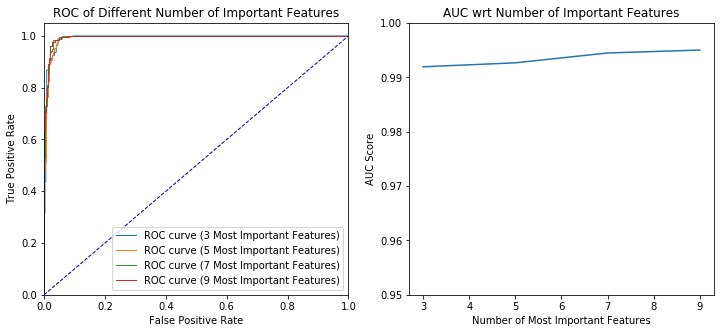

In [76]:
plt.figure(figsize = (12,5))
plt.subplot(1,2,1)
for i,j in enumerate(np.arange(3,10,2)):
    plt.plot(fpr[i], tpr[i], lw=1, label='ROC curve ('+str(j)+ ' Most Important Features)')

plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of Different Number of Important Features')
plt.legend(loc="lower right")

plt.subplot(1,2,2)
plt.plot(np.arange(3,10,2),auc)
plt.ylim([0.95,1])
plt.xlabel('Number of Most Important Features')
plt.ylabel('AUC Score')
plt.title('AUC wrt Number of Important Features')
plt.show()

Here is a nice discussion of using ROC curve.
http://www0.cs.ucl.ac.uk/staff/ucacbbl/roc/

## Focusing on small set of feature for interpretability

In [80]:
i=3
features_subset = ranked_features[0:i]
X_train_subset, X_test_subset = X_train[features_subset], X_test[features_subset]
lr = LogisticRegression()
lr.fit(X_train_subset,y_train)
y_train_predicted_lr = lr.predict(X_train_subset)
y_test_predicted_lr = lr.predict(X_test_subset)

Confusion matrix, without normalization
Confusion matrix, without normalization


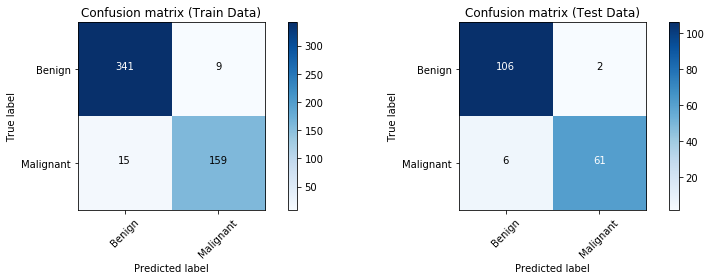

In [84]:
# Compute confusion matrix
confusion_matrix_train_lr = confusion_matrix(y_train, y_train_predicted_lr)
confusion_matrix_test_lr = confusion_matrix(y_test, y_test_predicted_lr)
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plot_confusion_matrix(confusion_matrix_train_lr, classes=['Benign','Malignant'],
                      title='Confusion matrix (Train Data)')
plt.subplot(1,2,2)
plot_confusion_matrix(confusion_matrix_test_lr, classes=['Benign','Malignant'],
                      title='Confusion matrix (Test Data)')
plt.show()

In [85]:
lr.coef_,lr.intercept_

(array([[ 0.47,  0.45,  0.37]]), array([-5.05]))

**Comment**: from here, we know that the three features: bare_nuclei, cell_size_uniformity, cell_shape_uniformity all contribute positively towards the probability of getting a Breast cancer, and their marginal effects are similar in magnitude.

### Logistic Regression Taking into Account Imbalance of the data

In [86]:
i=3
features_subset = ranked_features[0:i]
X_train_subset, X_test_subset = X_train[features_subset], X_test[features_subset]
lr = LogisticRegression(class_weight={0:1, 1:1.85})
lr.fit(X_train_subset,y_train)
y_train_predicted_lr = lr.predict(X_train_subset)
y_test_predicted_lr = lr.predict(X_test_subset)

Confusion matrix, without normalization
Confusion matrix, without normalization


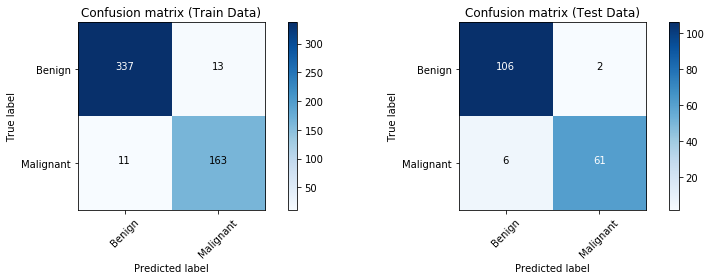

In [87]:
# Compute confusion matrix
confusion_matrix_train_lr = confusion_matrix(y_train, y_train_predicted_lr)
confusion_matrix_test_lr = confusion_matrix(y_test, y_test_predicted_lr)
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plot_confusion_matrix(confusion_matrix_train_lr, classes=['Benign','Malignant'],
                      title='Confusion matrix (Train Data)')
plt.subplot(1,2,2)
plot_confusion_matrix(confusion_matrix_test_lr, classes=['Benign','Malignant'],
                      title='Confusion matrix (Test Data)')
plt.show()

In [88]:
lr.coef_,lr.intercept_

(array([[ 0.52,  0.51,  0.41]]), array([-5.03]))

**Comment**: from here, we know that the three features: bare_nuclei, cell_size_uniformity, cell_shape_uniformity all contribute positively towards the probability of getting a Breast cancer, and their marginal effects are similar in magnitude.

In [82]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')